# Extended Kalman Filter

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from jax.ops import index_update
from pyprobml_utils import plot_ellipse

Kalman Filter
$$
\begin{align}
    {\bf z}_{t+1} &= {\bf Az}_{t} + \boldsymbol\varepsilon_t\\
    {\bf x}_{t+1} &= {\bf Cz}_{t} + \boldsymbol\varphi_t
\end{align}
$$

with
* $A \in \mathbb{R}^K \to \mathbb{R}^K$,
* $C \in \mathbb{R}^M \to \mathbb{R}^K$.

Extended Kalman Filter
$$
\begin{align}
    {\bf z}_{t+1} &= f_z({\bf z}_t) + \boldsymbol\varepsilon_t\\
    {\bf x}_{t+1} &= f_x({\bf z}_{t+1}) + \boldsymbol\varphi_t
\end{align}
$$

With 
* $f_z: \mathbb{R}^K\to \mathbb{R}^K$,
* $f_x: \mathbb{R}^K\to \mathbb{R}^M$.

In [3]:
%config InlineBackend.figure_format = "retina"

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

## The figure-8 system

$$
\begin{aligned}
    \dot x &= y\\
    \dot y &= x - x ^ 3
\end{aligned}
$$


* Extended kalman filter of continuous dynamics with discrete (skipped) measures

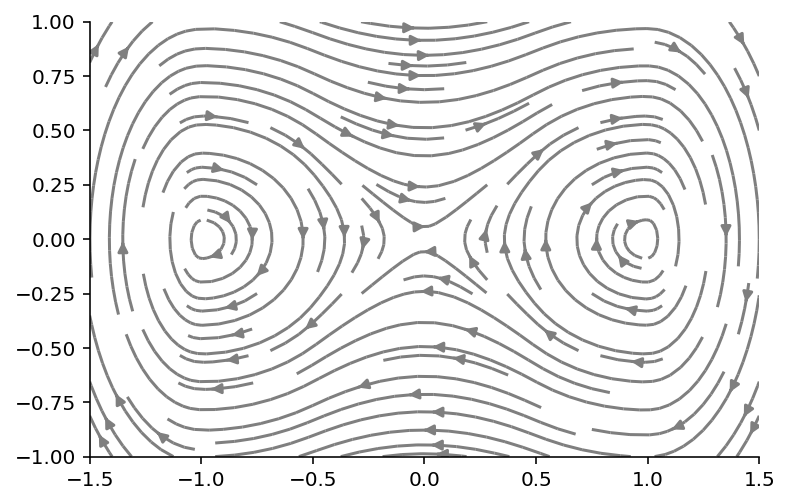

In [4]:
def fz(x):
    x, y = x
    return  jnp.asarray([y, x - x ** 3])

def fx(x):
    """
    Identity motion
    """
    x, y = x
    return jnp.asarray([x, y])

    
vmin, vmax, step = -1.5, 1.5 + 0.5, 0.5
X = jnp.mgrid[-1:1.5:step, vmin:vmax:step][::-1]
X_dot = jnp.apply_along_axis(fz, 0, X)
plt.streamplot(*X, *X_dot, density=1.1, color="tab:gray");

In [6]:
# forward-jacobian computation
Dfz = jax.jacfwd(fz)
Dfx = jax.jacfwd(fx)

In [7]:
dt = 0.01
nsteps = 1000
xn = jnp.array([0.5, -1.1])
xn = jnp.array([0.5, -0.6])

# State noise
Qt = jnp.eye(2) * 0.001
# Observed noise
Rt = jnp.eye(2) * 0.01

key = random.PRNGKey(314)
key_state, key_obs = random.split(key)


state_noise = random.multivariate_normal(key_state, jnp.asarray([0, 0]), Qt, (nsteps,))
obs_noise = random.multivariate_normal(key_obs, jnp.asarray([0, 0]), Rt, (nsteps,))

In [8]:
simulation = jnp.zeros((nsteps, 2))
simulation = index_update(simulation, 0, xn)

# Latent state: conservative system
for n in range(1, nsteps):
    # xn = xn + f(xn) * dt #+ errors[n] * jnp.sqrt(dt)
    k1 = fz(xn)
    k2 = fz(xn + dt * k1)
    xn = xn + dt * (k1 + k2) / 2 + state_noise[n] * jnp.sqrt(dt)
    simulation = index_update(simulation, n, xn)

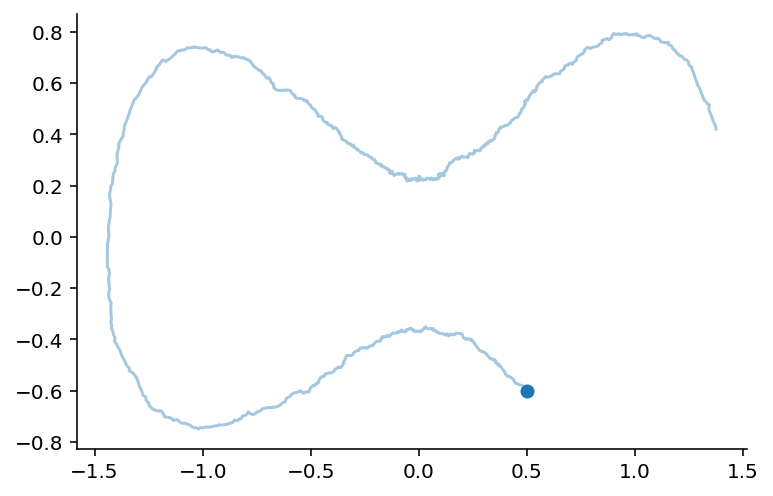

In [9]:
plt.scatter(*simulation[0], c="tab:blue")
plt.plot(*simulation.T, alpha=0.4)
# plt.plot(*simulation[::40].T, marker="o", linewidth=0, c="tab:blue")

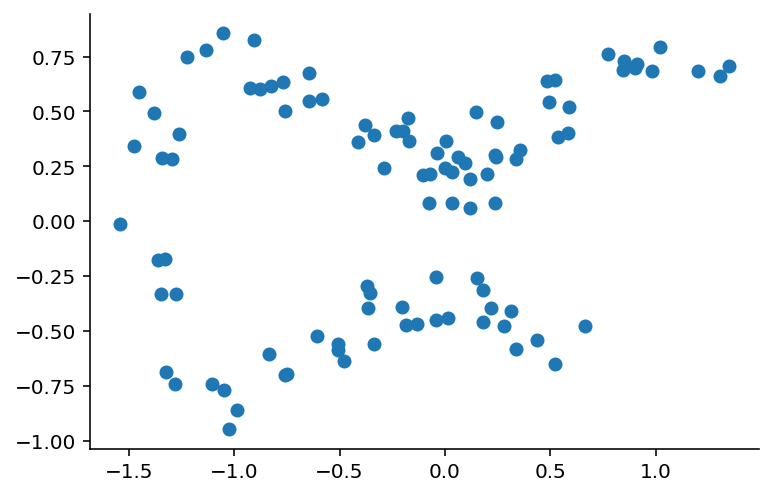

In [10]:
jump_size = 10
sample_state = simulation[::jump_size]
sample_obs = jnp.apply_along_axis(fx, 1, sample_state) + obs_noise[::jump_size]
n_obs = len(sample_obs)
plt.plot(*sample_obs.T, marker="o", linewidth=0)

In [11]:
def Vt_dot(V, G, Q): return G @ V @ G + Q
I = jnp.eye(2)

### First attempt

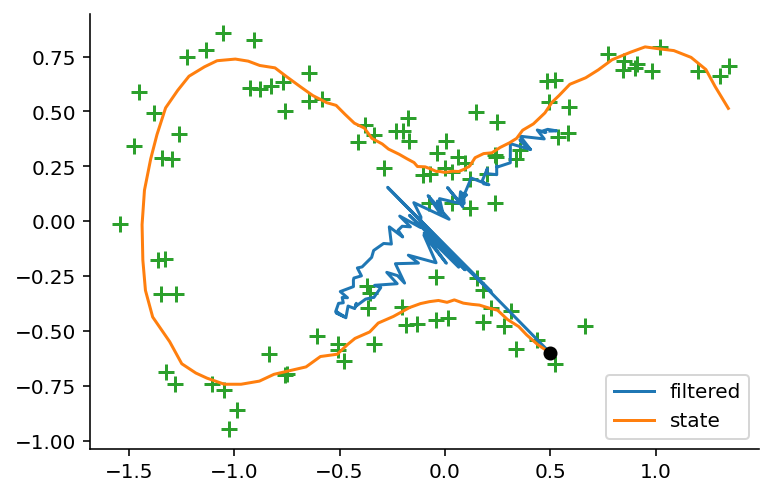

In [12]:
Vt = Rt.copy()
mu_t = simulation[0]
mu_hist = jnp.zeros((n_obs, 2))
V_hist = jnp.zeros((n_obs, 2, 2))

mu_hist = index_update(mu_hist, 0, mu_t)
V_hist = index_update(V_hist, 0, Vt)

for t in range(1, n_obs):
    ### --- ###
    mu_t_cond = fz(mu_t)
    
    Gt = Dfz(mu_t)
    Ht = Dfx(mu_t_cond)

    Vt_cond = Vt_dot(Vt, Gt, Qt)
    ### --- ###
    
    Kt = Vt_cond @ Ht.T @ jnp.linalg.inv(Ht @ Vt_cond @ Ht.T + Rt)
    mu_t = mu_t_cond + Kt @ (sample_obs[t] - mu_t_cond)
    Vt = (I - Kt @ Ht) @ Vt_cond
    
    mu_hist = index_update(mu_hist, t, mu_t)
    V_hist = index_update(V_hist, t, Vt)

plt.plot(*mu_hist.T, label="filtered")
plt.plot(*sample_state.T, label="state")
plt.scatter(*sample_obs.T, marker="+", s=60, c="tab:green")
plt.scatter(*mu_hist[0], c="black", zorder=3)
plt.legend()

### Second attempt
* Runge-Kutta (RK) update

In [13]:
Vt = Rt.copy()
mu_t = simulation[0]

mu_hist = jnp.zeros((n_obs, 2))
V_hist = jnp.zeros((n_obs, 2, 2))

mu_hist = index_update(mu_hist, 0, mu_t)
V_hist = index_update(V_hist, 0, Vt)

for t in range(1, n_obs):
    ### --- ###
    # rk2-update
    k1 = fz(mu_t)
    k2 = fz(mu_t + dt * k1)
    mu_t_cond = mu_t + dt * (k1 + k2) / 2
    
    Gt = Dfz(mu_t)
    Ht = Dfx(mu_t_cond)
    
    # rk2-update
    k1 = Vt_dot(Vt, Gt, Qt)
    k2 = Vt_dot(Vt + dt * k1, Gt, Qt)
    Vt_cond = Vt + dt * (k1 + k2) / 2
    ### --- ###
    
    Kt = Vt_cond @ Ht.T @ jnp.linalg.inv(Ht @ Vt_cond @ Ht.T + Rt)
    mu_t = mu_t_cond + Kt @ (sample_obs[t] - mu_t_cond)
    Vt = (I - Kt @ Ht) @ Vt_cond
    
    mu_hist = index_update(mu_hist, t, mu_t)
    V_hist = index_update(V_hist, t, Vt)

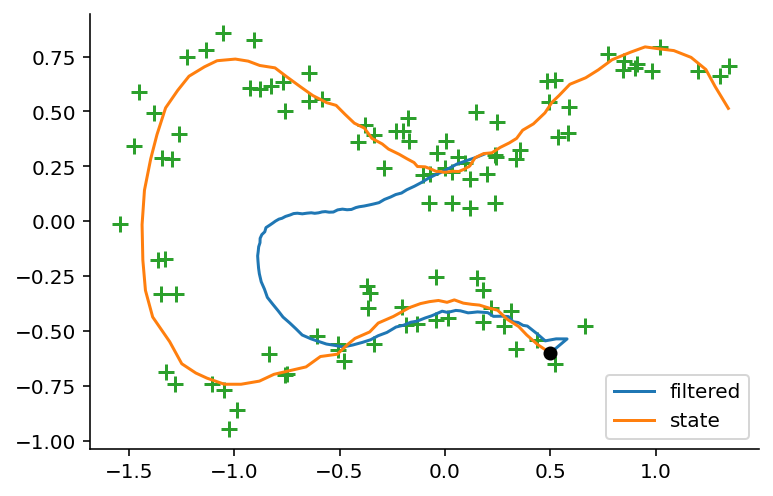

In [14]:
plt.plot(*mu_hist.T, label="filtered")
plt.plot(*sample_state.T, label="state")
plt.scatter(*sample_obs.T, marker="+", s=60, c="tab:green")
plt.scatter(*mu_hist[0], c="black", zorder=3)
plt.legend()

### third attempt
* RK update
* Update for however many steps we've skipped

In [15]:
Vt = Rt.copy()
mu_t = simulation[0]

mu_hist = jnp.zeros((n_obs, 2))
V_hist = jnp.zeros((n_obs, 2, 2))

mu_hist = index_update(mu_hist, 0, mu_t)
V_hist = index_update(V_hist, 0, Vt)

for t in range(1, n_obs):
    ### ---- ###
    # rk2-update
    # integrate up to the next update
    for _ in range(jump_size):
        k1 = fz(mu_t)
        k2 = fz(mu_t + dt * k1)
        mu_t = mu_t + dt * (k1 + k2) / 2
    mu_t_cond = mu_t
    
    Gt = Dfz(mu_t)
    Ht = Dfx(mu_t_cond)
    
    # rk2-update
    # Integrate up to the next update
    for _ in range(jump_size):
        k1 = Vt_dot(Vt, Gt, Qt)
        k2 = Vt_dot(Vt + dt * k1, Gt, Qt)
        Vt = Vt + dt * (k1 + k2) / 2
    Vt_cond = Vt
    ### ---- ###
    
    Kt = Vt_cond @ Ht.T @ jnp.linalg.inv(Ht @ Vt_cond @ Ht.T + Rt)
    mu_t = mu_t_cond + Kt @ (sample_obs[t] - mu_t_cond)
    Vt = (I - Kt @ Ht) @ Vt_cond
    
    mu_hist = index_update(mu_hist, t, mu_t)
    V_hist = index_update(V_hist, t, Vt)

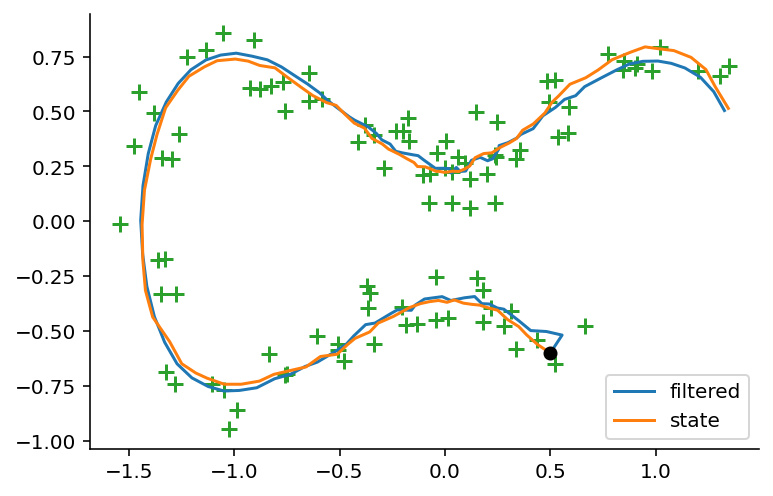

In [16]:
plt.plot(*mu_hist.T, label="filtered")
plt.plot(*sample_state.T, label="state")
plt.scatter(*sample_obs.T, marker="+", s=60, c="tab:green")
plt.scatter(*mu_hist[0], c="black", zorder=3)
plt.legend()

## Final Result

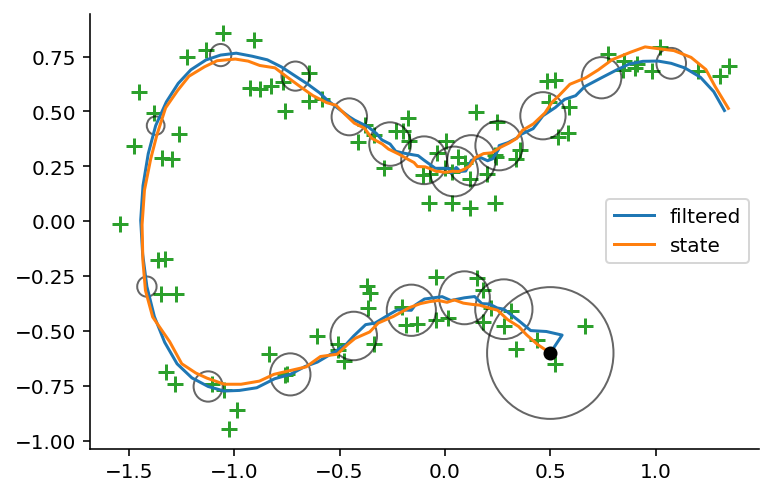

In [17]:
fig, ax = plt.subplots()
plt.plot(*mu_hist.T, label="filtered")
plt.plot(*sample_state.T, label="state")
plt.scatter(*sample_obs.T, marker="+", s=60, c="tab:green")
plt.scatter(*mu_hist[0], c="black", zorder=3)
for mut, Vt in zip(mu_hist[::5], V_hist[::5]):
    plot_ellipse(Vt, mut, ax, plot_center=False, alpha=0.6)
plt.legend()

(-1.6942082047462463, 1.5, -1.108426155900428, 1.0)

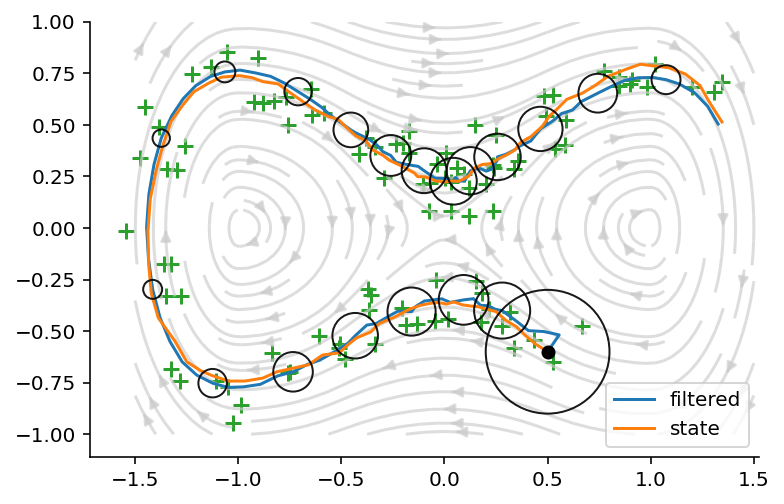

In [18]:
fig, ax = plt.subplots()
plt.plot(*mu_hist.T, label="filtered")
plt.plot(*sample_state.T, label="state")
plt.scatter(*sample_obs.T, marker="+", s=60, c="tab:green")
plt.scatter(*mu_hist[0], c="black", zorder=3)
for mut, Vt in zip(mu_hist[::5], V_hist[::5]):
    plot_ellipse(Vt, mut, ax, plot_center=False, alpha=0.9, zorder=3)
plt.legend()
field = ax.streamplot(*X, *X_dot, density=1.1, color="#ccccccaa")
plt.axis("equal")

# All together

In [140]:
def fz(x):
    x, y = x
    return  jnp.asarray([y, x - x ** 3])

def fx(x):
    """
    Identity motion
    """
    x, y = x
    return jnp.asarray([x, y])

In [212]:
class ExtendedKalmanFilter:
    """
    Implementation of the Extended Kalman Filter
    for a nonlinear-continous dynamical system
    """
    def __init__(self, fz, fx, Q, R):
        self.fz = fz
        self.fx = fx
        self.Dfz = jax.jacfwd(fz)
        self.Dfx = jax.jacfwd(fx)
        self.Q = Q
        self.R = R
        self.state_size, _ = Q.shape
        self.obs_size, _ = R.shape
        
    @staticmethod
    def _rk2(x0, f, nsteps, dt):
        """
        class-independent second-order Runge-Kutta method
        
        Parameters
        ----------
        f: function
            Function to integrate. Must return jax.numpy
        """
        input_dim, *_ = x0.shape
        simulation = jnp.zeros((nsteps, input_dim))
        simulation = index_update(simulation, 0, x0)
        
        xt = x0.copy()
        for t in range(1, nsteps):
            k1 = f(xt)
            k2 = f(xt + dt * k1)
            xt = xt + dt * (k1 + k2) / 2
            simulation = index_update(simulation, t, xt)
        return simulation
    
    def simulate(self, x0, key, T, n_samples, dt=0.01, noisy=False):
        """
        
        """
        nsteps = int(T // dt)
        jump_size = nsteps // n_samples
        key_state, key_obs = random.split(key)
        state_noise = random.multivariate_normal(key_state, jnp.zeros(self.state_size), self.Q, (nsteps,))
        obs_noise = random.multivariate_normal(key_obs, jnp.zeros(self.obs_size), self.R, (nsteps,)) 
        simulation = self._rk2(x0, self.fz, nsteps, dt)
        
        if noisy:
            simulation = simulation + jnp.sqrt(dt) * state_noise
        
        sample_state = simulation[::jump_size]
        sample_obs = jnp.apply_along_axis(self.fx, 1, sample_state) + obs_noise[:len(sample_state)]
        
        return sample_state, sample_obs, jump_size
    
    def estimate(self, sample_state, sample_obs, jump_size, dt):
        n_samples = len(sample_state)
        Vt = self.R.copy()
        mu_t = sample_state[0]

        mu_hist = jnp.zeros((n_samples, self.state_size))
        V_hist = jnp.zeros((n_samples, self.state_size, self.state_size))

        mu_hist = index_update(mu_hist, 0, mu_t)
        V_hist = index_update(V_hist, 0, Vt)

        for t in range(1, n_samples):
            for _ in range(jump_size):
                k1 = self.fz(mu_t)
                k2 = self.fz(mu_t + dt * k1)
                mu_t = mu_t + dt * (k1 + k2) / 2

                Gt = self.Dfz(mu_t)
                k1 = Vt_dot(Vt, Gt, self.Q)
                k2 = Vt_dot(Vt + dt * k1, Gt, self.Q)
                Vt = Vt + dt * (k1 + k2) / 2
            
            mu_t_cond = mu_t
            Vt_cond = Vt
            Ht = self.Dfx(mu_t_cond)

            Kt = Vt_cond @ Ht.T @ jnp.linalg.inv(Ht @ Vt_cond @ Ht.T + self.R)
            mu_t = mu_t_cond + Kt @ (sample_obs[t] - mu_t_cond)
            Vt = (I - Kt @ Ht) @ Vt_cond

            mu_hist = index_update(mu_hist, t, mu_t)
            V_hist = index_update(V_hist, t, Vt)
        
        return mu_hist, V_hist

In [213]:
dt = 0.01
T = 7.5
nsamples = 70
nsteps = 1000
xn = jnp.array([0.5, -0.75])

# State noise
Qt = jnp.eye(2) * 0.001
# Observed noise
Rt = jnp.eye(2) * 0.01

key = random.PRNGKey(314)

ekf = ExtendedKalmanFilter(fz, fx, Qt, Rt)
sample_state, sample_obs, jump = ekf.simulate(xn, key, T, nsamples)

mu_hist, V_hist = ekf.estimate(sample_state, sample_obs, jump, dt)

Text(0.5, 1.0, 'State Space')

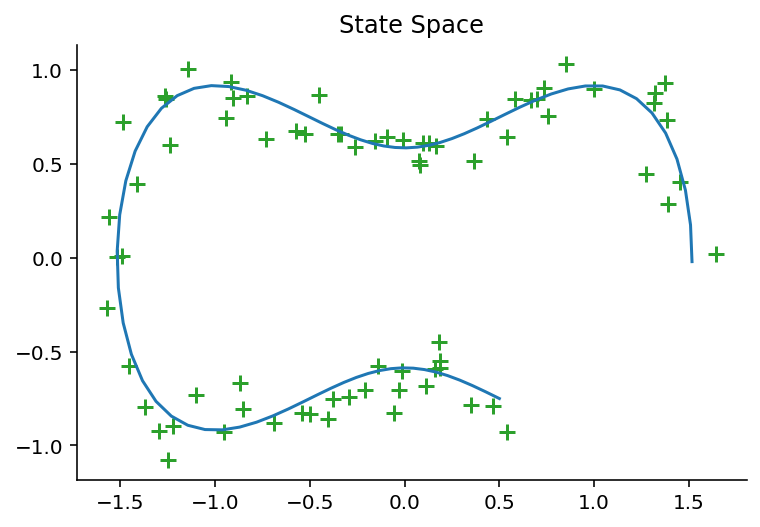

In [214]:
plt.plot(*sample_state.T)
plt.scatter(*sample_obs.T, marker="+", c="tab:green", s=60)
plt.title("State Space")

Text(0.5, 1.0, 'Observed Space')

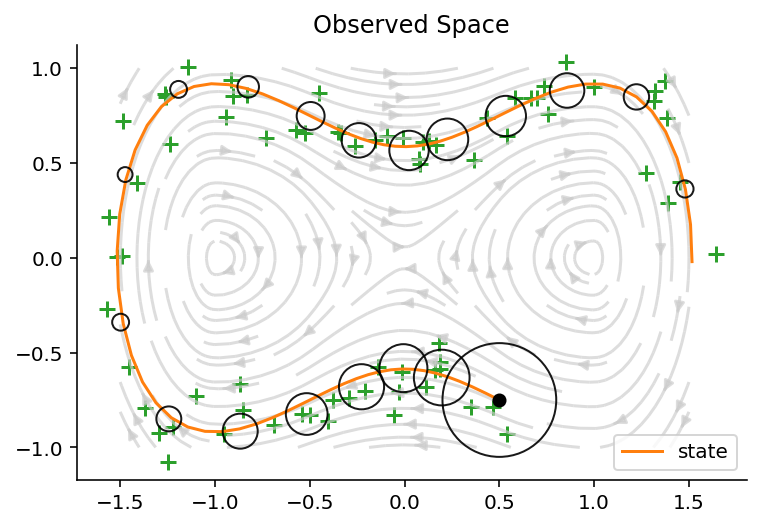

In [215]:
fig, ax = plt.subplots()

plt.plot(*sample_state.T, label="state", c="tab:orange")
plt.scatter(*sample_obs.T, marker="+", s=60, c="tab:green")
plt.scatter(*mu_hist[0], c="black", zorder=3)
for mut, Vt in zip(mu_hist[::4], V_hist[::4]):
    plot_ellipse(Vt, mut, ax, plot_center=False, alpha=0.9, zorder=3)
plt.legend()
field = ax.streamplot(*X, *X_dot, density=1.1, color="#ccccccaa")
plt.axis("equal")
plt.title("Observed Space")

## References
* https://en.wikipedia.org/wiki/Extended_Kalman_filter
* http://www.math.iit.edu/~fass/478578_Chapter_3.pdf